<a href="https://colab.research.google.com/github/sakira/TensorflowInPractice/blob/master/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!wget --no-check-certificate \
  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
  -O /tmp/sunspots.csv

--2019-12-31 14:03:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2019-12-31 14:03:07 (133 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [0]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))




In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# setup the data and create the dataset
def plot_series(time, series, format='-', start=0, end=None):
  #plt.figure(figsize=(10, 6))
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('time')
  plt.ylabel('value')
  plt.grid(True)

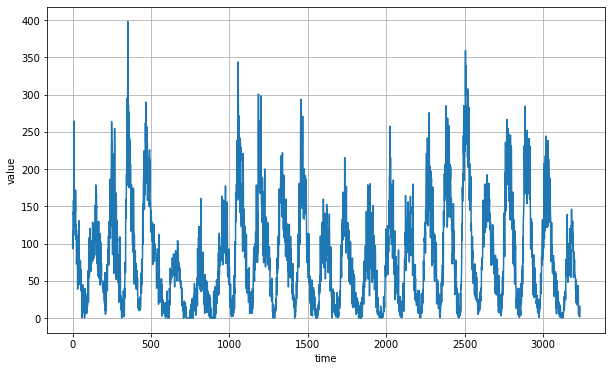

In [29]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()


split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 64
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

  series = tf.expand_dims(series, axis=-1)

  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1], window[-1]) )
  dataset = dataset.batch(batch_size).prefetch(1)
  

  return dataset


def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 100**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
23/23 [==============================] - 3s 139ms/step - loss: 83.4888 - mae: 83.9705
Epoch 2/100
23/23 [==============================] - 1s 38ms/step - loss: 79.1863 - mae: 79.6765
Epoch 3/100
23/23 [==============================] - 1s 37ms/step - loss: 76.6705 - mae: 77.1614
Epoch 4/100
23/23 [==============================] - 1s 42ms/step - loss: 74.7575 - mae: 75.2558
Epoch 5/100
23/23 [==============================] - 1s 39ms/step - loss: 72.8337 - mae: 73.3431
Epoch 6/100
23/23 [==============================] - 1s 40ms/step - loss: 70.7724 - mae: 71.2547
Epoch 7/100
23/23 [==============================] - 1s 40ms/step - loss: 68.4953 - mae: 68.9893
Epoch 8/100
23/23 [==============================] - 1s 39ms/step - loss: 66.0986 - mae: 66.5877
Epoch 9/100
23/23 [==============================] - 1s 40ms/step - loss: 63.6465 - mae: 64.1470
Epoch 10/100
23/23 [==============================] - 1s 38ms/step - loss: 61.2627 - mae: 61.7587
Epoch 11/100
23/23 [========

[1e-08, 0.01, 0, 100]

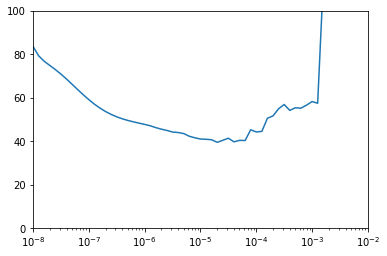

In [39]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-2, 0, 100])

In [40]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(train_set, epochs=500)

Epoch 1/500
23/23 [==============================] - 3s 151ms/step - loss: 54.4421 - mae: 54.9411
Epoch 2/500
23/23 [==============================] - 1s 38ms/step - loss: 46.6723 - mae: 47.1740
Epoch 3/500
23/23 [==============================] - 1s 38ms/step - loss: 43.5836 - mae: 44.0775
Epoch 4/500
23/23 [==============================] - 1s 40ms/step - loss: 42.2252 - mae: 42.7284
Epoch 5/500
23/23 [==============================] - 1s 39ms/step - loss: 41.1890 - mae: 41.6917
Epoch 6/500
23/23 [==============================] - 1s 41ms/step - loss: 41.0879 - mae: 41.5802
Epoch 7/500
23/23 [==============================] - 1s 40ms/step - loss: 41.5594 - mae: 42.0593
Epoch 8/500
23/23 [==============================] - 1s 37ms/step - loss: 40.5063 - mae: 41.0002
Epoch 9/500
23/23 [==============================] - 1s 36ms/step - loss: 40.4132 - mae: 40.9118
Epoch 10/500
23/23 [==============================] - 1s 40ms/step - loss: 39.9460 - mae: 40.4491
Epoch 11/500
23/23 [========

24.616337


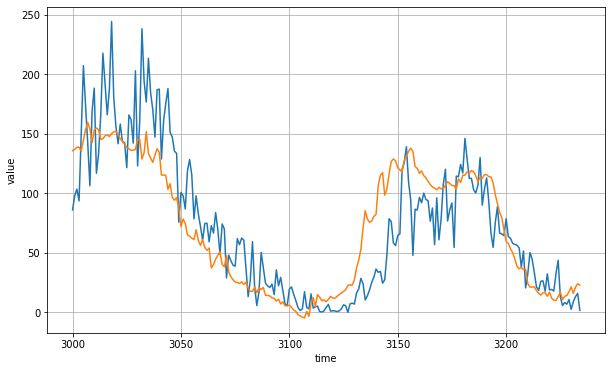

In [41]:
simple_forecast = model_forecast(model, series[..., np.newaxis], window_size)
simple_forecast = simple_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, simple_forecast)

print(tf.keras.metrics.mean_absolute_error(x_valid, simple_forecast).numpy())

<Figure size 432x288 with 0 Axes>

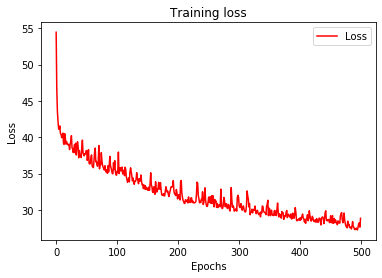

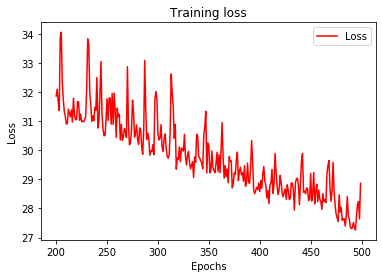

<Figure size 432x288 with 0 Axes>

In [42]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(20, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  
])
  
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss='mse',
              optimizer=optimizer)
history = model.fit(dataset, epochs=100, verbose=0)

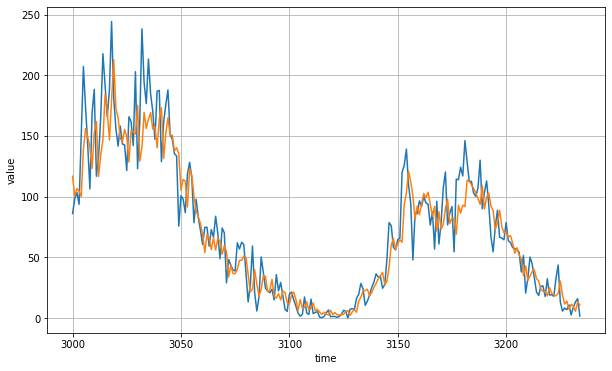

In [21]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [24]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.754762


In [20]:
simple_forecast = model_forecast(model, series[..., np.newaxis], window_size)
simple_forecast = simple_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, simple_forecast)

print(tf.keras.metrics.mean_absolute_error(x_valid, simple_forecast).numpy())

ValueError: ignored